# Autoencoders Tutorial
From F. Chollet's blogs.keras.io
## Simple 1-hidden layer
1 dense layer as both encoder and decoder.
We will be working on MNIST dataset, i.e. 28 x 28 = 784 points in black and white

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Using TensorFlow backend.


Encoder on its own

In [2]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

Decoder on its own

In [3]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

We define the loss as binary cross-entropy (pixel by pixel) and pick the Adadelta optimizer (works with Adam too)

In [4]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Now we read and prepare the MNIST digits data. We are not interested in labels (autoencoders are not supervised).
We scale the luminosity between 0.0 and 1.0, then flatten them into  784-element vectors

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


Train the autoencoder: input and target values are the same

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.3575 - val_loss: 0.2716
Epoch 2/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.2651 - val_loss: 0.2552
Epoch 3/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.2462 - val_loss: 0.2347
Epoch 4/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.2266 - val_loss: 0.2161
Epoch 5/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.2106 - val_loss: 0.2027
Epoch 6/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1990 - val_loss: 0.1925
Epoch 7/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1899 - val_loss: 0.1844
Epoch 8/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1825 - val_loss: 0.1778
Epoch 9/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1764 - val_loss: 0.1721
Epoch

Let us encode a few images, decode them again and plot them for comparison

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

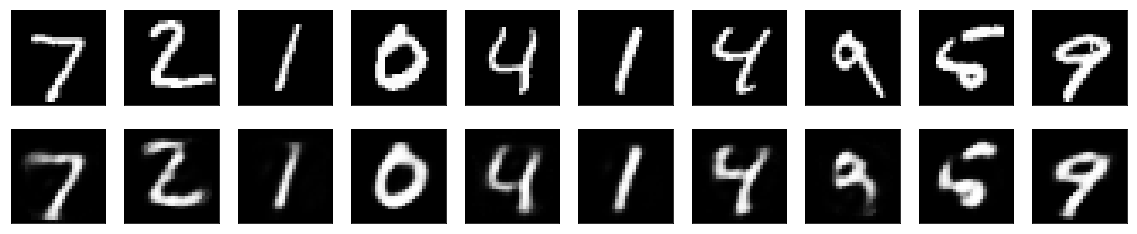

In [11]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Readable, but definitely "fuzzier". 

## Deep Autoencoder
Multiple layers, descending to 32-D gradually

In [33]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [34]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.3447 - val_loss: 0.2649
Epoch 2/100
60000/60000 [==============================] - 1s 18us/step - loss: 0.2584 - val_loss: 0.2552
Epoch 3/100
60000/60000 [==============================] - 1s 18us/step - loss: 0.2483 - val_loss: 0.2414
Epoch 4/100
60000/60000 [==============================] - 1s 18us/step - loss: 0.2371 - val_loss: 0.2300
Epoch 5/100
60000/60000 [==============================] - 1s 18us/step - loss: 0.2258 - val_loss: 0.2206
Epoch 6/100
60000/60000 [==============================] - 1s 18us/step - loss: 0.2151 - val_loss: 0.2061
Epoch 7/100
60000/60000 [==============================] - 1s 18us/step - loss: 0.2000 - val_loss: 0.1905
Epoch 8/100
60000/60000 [==============================] - 1s 18us/step - loss: 0.1883 - val_loss: 0.1840
Epoch 9/100
60000/60000 [==============================] - 1s 18us/step - loss: 0.1811 - val_loss: 0.1

In [35]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [36]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

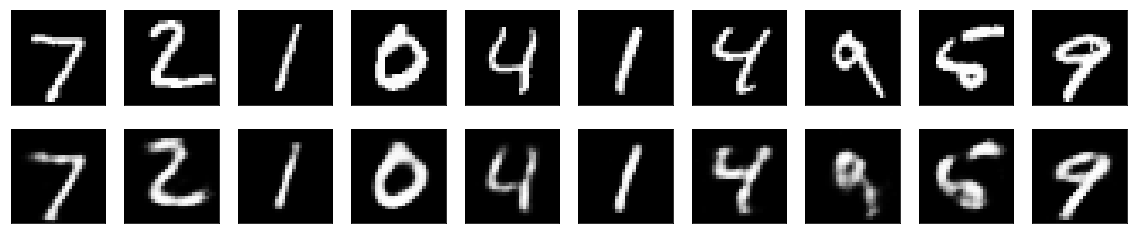

In [37]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

A bit better

## Convolutional Autoencoders
Inputs and outputs are images. It makes sense to use convolution networks

In [38]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

No need to flatten with convolution network - we can use the original pictures

In [39]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

To see progress, start a tensorboard server with tensorboard --logdir=./logs, then open http://localhost:6006.
Note that tensorboard does slow things down a bit. Recommend use of GPU.

In [40]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='./logs')]
               )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 74us/step - loss: 0.2113 - val_loss: 0.1667
Epoch 2/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.1572 - val_loss: 0.1499
Epoch 3/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.1419 - val_loss: 0.1386
Epoch 4/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.1330 - val_loss: 0.1307
Epoch 5/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.1280 - val_loss: 0.1256
Epoch 6/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.1247 - val_loss: 0.1214
Epoch 7/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.1221 - val_loss: 0.1240
Epoch 8/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.1196 - val_loss: 0.1202
Epoch 9/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.1177 - val_loss: 0.1203
Epoch

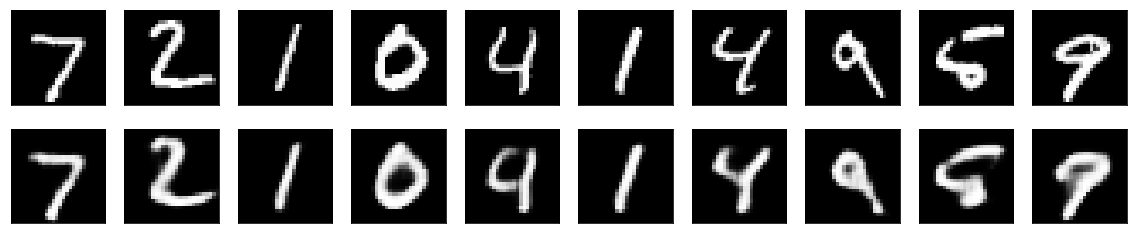

In [41]:
decoded_imgs = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1+ n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

A lot clearer!
Now let us have a look at the encoded images. They are tensors of 8x4x4, so we reshape them to 4x32 to display in 2D

In [42]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
encoded_imgs=encoder.predict(x_test)

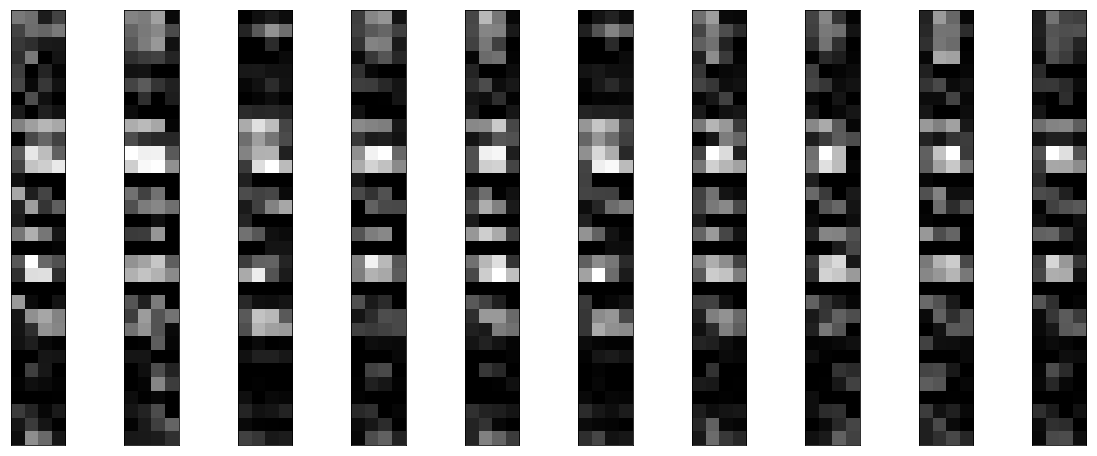

In [43]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4*8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Denoising Autoencoders
Let's add a gaussian noise generator to our data, then apply our convolutional autoencoder

In [44]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Plot the noisy digits

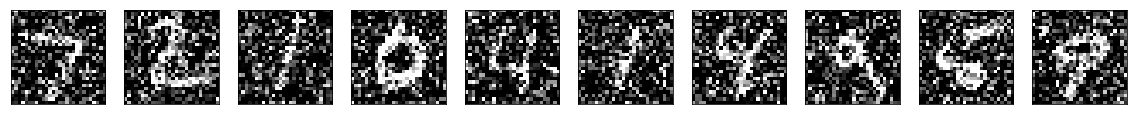

In [46]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Build Convolutional autoencoder with more filters (32 vs. 16)

In [47]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Train on noisy data

In [48]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 48us/step - loss: 0.1762 - val_loss: 0.1205
Epoch 2/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1177 - val_loss: 0.1115
Epoch 3/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1109 - val_loss: 0.1065
Epoch 4/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1074 - val_loss: 0.1049
Epoch 5/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1053 - val_loss: 0.1053
Epoch 6/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1037 - val_loss: 0.1016
Epoch 7/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1027 - val_loss: 0.1005
Epoch 8/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1019 - val_loss: 0.1011
Epoch 9/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1014 - val_loss: 0.1

Let's find out if we can filter out the noise

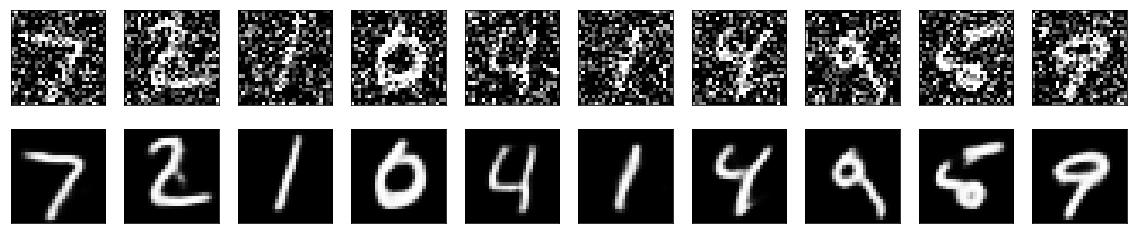

In [49]:
decoded_imgs = autoencoder.predict(x_test_noisy)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1+ n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Variational Autoencoders
Encoder network maps to latent space with 2-D normal distribution, decoder samples latent space and reconstructs images

some imports

In [160]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Utility Function

In [161]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

Parameters for MNIST dataset

In [162]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

Build encoder to 2D latent space

In [163]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

Sample from latent space

In [164]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
import tensorflow as tf
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [165]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

Now create the encoder

In [166]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_38[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_38[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

Build the decoder from sampled latent space to reconstruction

In [167]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_40 (Dense)             (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


Put it all together

In [168]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [169]:
models = (encoder, decoder)
data = (x_test, y_test)

Define loss function as x-entropy + KL divergence (can also use mse)

In [170]:
#VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = mse(inputs, outputs)

In [171]:
# if you choose binary cross_entropy, you'll find a bug that prevents differentiation
#reconstruction_loss = binary_crossentropy(inputs,outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss+kl_loss)

vae.add_loss(vae_loss)

Compile the model

In [172]:
vae.compile(optimizer='adam')
vae.summary()
# plot_model(vae, to_file='vae_mlp.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


Train the autoencoder

In [173]:
vae.fit(x_train, epochs=200, batch_size=batch_size, validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')

60000/60000 [==============================] - 2s 28us/step - loss: 39.9694 - val_loss: 39.8644
Epoch 10/200
60000/60000 [==============================] - 2s 27us/step - loss: 39.7535 - val_loss: 39.6618
Epoch 11/200
60000/60000 [==============================] - 2s 28us/step - loss: 39.5579 - val_loss: 39.5042
Epoch 12/200
60000/60000 [==============================] - 2s 28us/step - loss: 39.3875 - val_loss: 39.4262
Epoch 13/200
60000/60000 [==============================] - 2s 28us/step - loss: 39.2206 - val_loss: 39.2601
Epoch 14/200
60000/60000 [==============================] - 2s 28us/step - loss: 39.0798 - val_loss: 39.1348
Epoch 15/200
60000/60000 [==============================] - 2s 28us/step - loss: 38.9546 - val_loss: 39.0158
Epoch 16/200
60000/60000 [==============================] - 2s 28us/step - loss: 38.8115 - val_loss: 38.9103
Epoch 17/200
60000/60000 [==============================] - 2s 28us/step - loss: 38.6937 - val_loss: 38.8901
Epoch 18/200
60000/60000 [======

Finally plot the result!

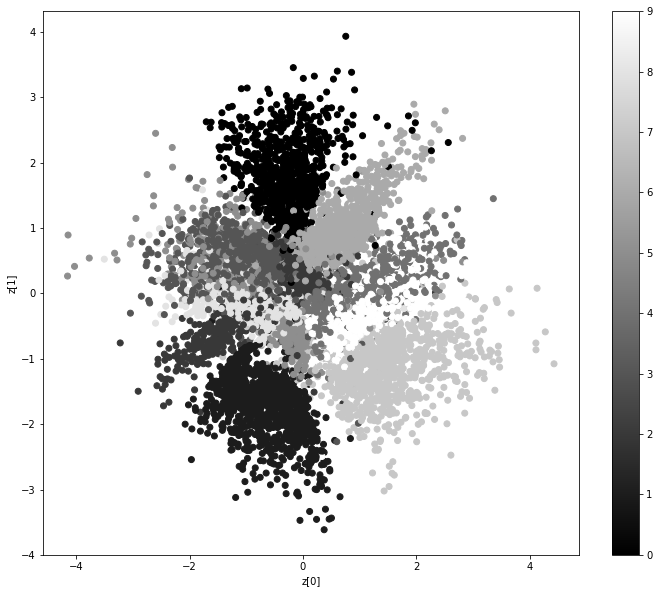

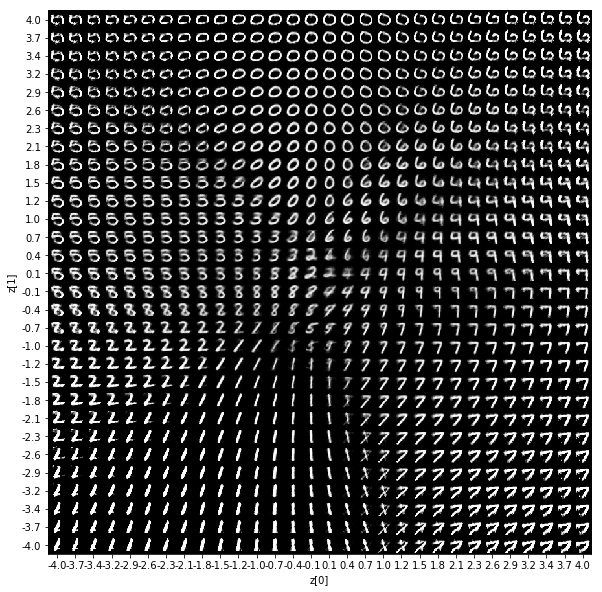

In [174]:
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")